#Install Necessary Libraries/Packages

In [ ]:
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
%pip install geopandas
!pip install descartes
!pip install contextily
!pip install sodapy
!pip install colab-env -qU

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import contextily as ctx
import sodapy
from sodapy import Socrata
import requests

In [ ]:
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
tileProvider = get_provider('CARTODBPOSITRON_RETINA')

from bokeh.io import output_notebook, show, output_file, save
from bokeh.plotting import figure
from bokeh.models import HoverTool,GeoJSONDataSource
from bokeh.layouts import row, column
from bokeh.models.widgets import Div

output_notebook()

TOOLS="pan,wheel_zoom,box_zoom,reset,save"

#Read Census Data

In [ ]:
mykey = 'my key'
base = 'https://api.census.gov/data/2020/acs/acs5?get=GEO_ID,NAME,'
geogcnty = '&for=county:*&key='
f_list = ['C24050_001E', 'C24050_001M', 'C24050_004E', 'C24050_004M', 'C24050_011E','C24050_011M'] #Total Persons, Total persons Black or African American Alone Est and MOE
fields =  ",".join(f_list)

urlcnty = base+fields+geogcnty+mykey

In [ ]:
print(urlcnty)

https://api.census.gov/data/2020/acs/acs5?get=GEO_ID,NAME,C24050_001E,C24050_001M,C24050_004E,C24050_004M,C24050_011E,C24050_011M&for=county:*&key=16fc7029ce4f8097dc2043fd5751975e4e95190f


In [ ]:
mydpath='my path'

In [ ]:
r = requests.get(urlcnty)
data = r.json()


labels = data[0][0:]
del data[:1]
df=pd.DataFrame.from_dict(data,orient = 'columns')
df.columns=labels
testgeo=df['GEO_ID'].str.split(pat='US', expand=True)
df.insert(loc = 1, column = 'geoid', value = testgeo[1])
filename='Civilian16.csv'
df.to_csv(mydpath+filename)

In [ ]:
df = gpd.read_file("/content/Civilian16.csv")

In [ ]:
df['C24050_001M']=df.C24050_001M.astype(int)
df.loc[df.C24050_001M < 0,'C24050_001M' ]=0

In [ ]:
df.tail()

Getting aliases for the columns intended to work with:

In [ ]:
df["TotEst"] = df["C24050_001E"]
df["TotMar"] = df["C24050_001M"]
df["ManuEst"] = df["C24050_004E"]
df["ManuMar"] = df["C24050_004M"]
df["HESEst"] = df["C24050_011E"]
df["HESMar"] = df["C24050_011M"]

In [ ]:
df.head()

### Get the Geometry (Link with Census Data by GeoID)

In [ ]:
import urllib.request

urlco="https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_20m.zip" #Download the data rather than loading from the link
fn = urlco.split('/')[-1]

print('Downloading shapefile...')

%time urllib.request.urlretrieve(urlco, fn)

In [ ]:
zip = "/content/drive/MyDrive/GEG584_UMEOBI/Data/cb_2021_us_county_20m.zip" #County Data downloaded and uploaded

In [ ]:
zipfile = f"zip://{fn}"
cos = gpd.read_file(zip)

In [ ]:
cos.head(2)

In [ ]:
import os

In [ ]:
if os.path.exists(zip):
  os.remove(zip)
else:
  print("The file does not exist")

In [ ]:
cnty = cos.loc[~cos.STATE_NAME.isin(['Alaska','Hawaii','Puerto Rico'])].copy() # Dropping other guys
cnty.to_crs('epsg:3857',inplace=True)
cnty.shape[0]

In [ ]:
gdf = pd.merge(cnty,df,left_on='GEOID',right_on='geoid',how ='left')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
gdf.tail()

After loading the county data, there is a second geometry column called "geometry_y". Due to the fact that two geometries cannot exist in the same geo gataframe as well as the absece of values in the y geom, geometry_y should be dropped from the dataset

In [ ]:
gdf.drop("geometry_y", axis = 1, inplace=True)

# Finding the Margin of Error and Percentages Columns

In [ ]:
#Manufacturing Percentage
def pct_e(e1,e2):
  if e1>0:
    pct=(e2/e1)*100
  else:
    pct=0
  return pct


#HSE
def pct_moe(pct,e1,m1,m2):
  pt1 =(m2/1.645)**2
  pt2 = (pct/100)**2*(m1/1.645)**2
  if pt1>pt2:
    pMOE = ((1/e1)*((pt1-pt2)**.5)*1.645)*100
  else:
    pMOE = ((1/e1)*((pt1+pt2)**.5)*1.645)*100
  return pMOE

The margin of error and percentages cannot be properly used in future if they remain in the object data type. They are needed as integers.

Changing only the aliased columns' types:

In [ ]:
gdf["TotEst"] = gdf["TotEst"].astype(int)

In [ ]:
gdf["ManuEst"] = gdf["ManuEst"].astype(int)

In [ ]:
gdf["ManuMar"] = gdf["ManuMar"].astype(int)

In [ ]:
gdf["HESMar"] = gdf["HESMar"].astype(int)

In [ ]:
gdf["TotMar"] = gdf["TotMar"].astype(int)

In [ ]:
gdf["HESEst"] = gdf["HESEst"].astype(int)

In [ ]:
gdf.info()

### Percentage Columns

In [ ]:
gdf["pctManu"] = gdf.apply(lambda x: pct_e(x["TotEst"], x["ManuEst"]), axis=1) #Get the percentage of manufacturing

gdf['pctHES'] = gdf.apply(lambda x: pct_e(x['TotEst'], x['HESEst']), axis=1) #Get the percentage of HES
gdf.head(1)

### Margin of Error Columns

In [ ]:
gdf['moeManu'] = gdf.apply(lambda x: pct_moe(x['pctManu'], x['TotEst'], x['TotMar'], x['ManuMar']), axis=1) #Get the MOE of manufacturing
gdf['moeHES'] = gdf.apply(lambda x: pct_moe(x['pctHES'], x['TotEst'], x['TotMar'], x['HESMar']), axis=1) #Get the MMOE of manufacturing

gdf.head(1)

Ensuring the data types are all calculable:

In [ ]:
gdf.info()

# Determining the Reliability of Estimates

Columns to be used:

In [ ]:
main_list = ["TotEst", "TotMar", "ManuEst", "ManuMar", "HESEst", "HESMar"]
main_list

Creating the CV Columns:

In [ ]:
gdf[main_list] = gdf[main_list].apply(pd.to_numeric) #Convert all variables to numeric from object
gdf = gdf.loc[gdf.ManuEst > 0].copy()
gdf = gdf.loc[gdf.HESEst > 0].copy()
gdf.reset_index(inplace=True)

gdf['Manu_CV'] = ((gdf['ManuMar']/1.645)/gdf['ManuEst'])*100
gdf['HES_CV'] = ((gdf['HESMar']/1.645)/gdf['HESEst'])*100

Creating the reliability categorical columns:

In [ ]:
gdf['rankManu'] = pd.cut(gdf['Manu_CV'], [0,12,40,100], labels=['High','Medium','Low'], right=False)
gdf['rankHES'] = pd.cut(gdf['HES_CV'], [0,12,40,100], labels=['High','Medium','Low'], right=False)

In [ ]:
gdf.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Mapping The Reliability

In [ ]:
kwargs = {'plot_width':800,'plot_height':700,
         'sizing_mode':'scale_both',
         'outline_line_color':'#046626',
         'outline_line_width':3,'outline_line_alpha':.3,
         'toolbar_location':'above','border_fill_color':'#4287f5',
         'border_fill_alpha':.3,'min_border_left':20,
         'min_border_right':20,'min_border_top':10,
         'min_border_bottom':20}

In [ ]:
gdf['color'] = 'red'
gdf.loc[gdf['rankManu']=='High','color']='green'
gdf.loc[gdf['rankManu']=='Medium','color']='lightgray'

In [ ]:
mypath = "my path"

Bokeh cannot read the geometry field in any other name but "geometry". Thus, the main geomrtry ("geometry_x" column) will be replaced as "geometry" and dropped from the dataset as two geometries cannot exist in one dataframe.

In [ ]:
gdf["geometry"] = gdf["geometry_x"]

In [ ]:
gdf.drop("geometry_x", axis = 1, inplace=True)

#### Reliabilty of estimates for Manufacturing Workers by County

In [ ]:
output_file(mypath+"WorkersCopy.html", title="Reliabilty of estimates for Manufacturing Workers")

f1 = figure(title="Reliabilty of estimates for Manufacturing Workers by County", tools=TOOLS,**kwargs)
f1.add_tile(tileProvider)

f1.xaxis.visible = False
f1.yaxis.visible = False

f1.title.text_font_style = "italic"
f1.title.text_font_size = '10pt'

corel = gdf[['geometry','Manu_CV','rankManu','ManuEst','ManuMar','NAMELSAD','color']]
corel.reset_index(inplace=True)
poly_source1 = GeoJSONDataSource(geojson=corel.to_json())

cos = f1.patches('xs','ys',source=poly_source1,color='color',fill_alpha=.6)

colormap={'High':'green','Medium':'lightgray','Low':'red'}
for risk in colormap.keys():
    df = corel[corel['rankManu']==risk]
    point_source = GeoJSONDataSource(geojson=df.to_json())
    c=f1.circle('x', 'y',size=1, color=colormap[risk], fill_alpha=.7, legend_label=risk, source=point_source)

co_hover = HoverTool(renderers=[cos])
co_hover.point_policy = "follow_mouse"
co_hover.tooltips=[
    ("Name","@NAMELSAD"),
    ("Manufacturing Workers", "@ManuEst{0,0} (+/-@ManuMar{0,0})"),
    ('CV','@Manu_CV{0,0}%'),
    ("Reliability", "@rankManu")
]
f1.add_tools(co_hover)

# heading fills available width
heading = Div(text="""<h1>Reliability of Estimates</h1>\
<p>The map below shows the reliabilty of estimates of Manufacturing Workers Alone by county. \
</p>\
<p>Use the tools to pan, zoom, etc.. \
Hover over a polygon to see the estimate, margin of error, and CV.</p>\
<p><b><i>Data Sources:</i></b> American Community Survey, 2020, 5 yr. Table.</p>\
<p style='font-size:9px;'>Maps created by Henrietta Ebubechukwu Umeobi</p>""")   #, sizing_mode="stretch_both"

layout = column(heading, row(f1), margin=(5,5,5,5), sizing_mode="stretch_both")
show(layout)

#### Reliabilty of estimates for Educational Services, Health Care and Social Assistance Workers by County

In [ ]:
output_file(mypath+"HealthWorkersCopy.html", title="Reliabilty of estimates for Educational Services, Health Care and Social Assistance Workers")

f1 = figure(title="Reliabilty of estimates for Educational Services, Health Care and Social Assistance Workers by County", tools=TOOLS,**kwargs)
f1.add_tile(tileProvider)

f1.xaxis.visible = False
f1.yaxis.visible = False

f1.title.text_font_style = "italic"
f1.title.text_font_size = '10pt'

corel = gdf[['geometry','HES_CV','rankHES','HESEst','HESMar','NAMELSAD','color']]
corel.reset_index(inplace=True)
poly_source1 = GeoJSONDataSource(geojson=corel.to_json())

cos = f1.patches('xs','ys',source=poly_source1,color='color',fill_alpha=.6)

colormap={'High':'green','Medium':'lightgray','Low':'red'}
for risk in colormap.keys():
    df = corel[corel['rankHES']==risk]
    point_source = GeoJSONDataSource(geojson=df.to_json())
    c=f1.circle('x', 'y',size=1, color=colormap[risk], fill_alpha=.7, legend_label=risk, source=point_source)

co_hover = HoverTool(renderers=[cos])
co_hover.point_policy = "follow_mouse"
co_hover.tooltips=[
    ("Name","@NAMELSAD"),
    ("Manufacturing Workers", "@HESEst{0,0} (+/-@HESMar{0,0})"),
    ('CV','@HES_CV{0,0}%'),
    ("Reliability", "@rankHES")
]
f1.add_tools(co_hover)

# heading fills available width
heading = Div(text="""<h1>Reliability of Estimates</h1>\
<p>The map below shows the reliabilty of estimates of Educational Services, Health Care and Social Assistance Workers Alone by county. \
</p>\
<p>Use the tools to pan, zoom, etc.. \
Hover over a polygon to see the estimate, margin of error, and CV.</p>\
<p><b><i>Data Sources:</i></b> American Community Survey, 2020, 5 yr. Table.</p>\
<p style='font-size:9px;'>Maps created by Henrietta Ebubechukwu Umeobi</p>""")   #, sizing_mode="stretch_both"

layout = column(heading, row(f1), margin=(5,5,5,5), sizing_mode="stretch_both")
show(layout)

Verifying the range of valiues for these reliability estimates:

In [ ]:
gdf['rankManu'].value_counts()

In [ ]:
gdf['rankHES'].value_counts()

Ensuring all data types are good enough for conversion to a saved file:

In [ ]:
gdf.info()

Getting rid of out-of-bounds and NaN values:

In [ ]:
import numpy as np

In [ ]:
# Replace infinite updated data with nan
gdf["Manu_CV"].replace([np.inf, -np.inf], np.nan, inplace=True)
gdf["HES_CV"].replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
# Drop rows with NaN
gdf.dropna(subset=["Manu_CV", "HES_CV", "rankManu", "rankHES"], how="any", inplace=True)

In [ ]:
gdf.head()

In [ ]:
gdf.shape

# Getting Z-Scores Columns

In [ ]:
gdf['z_manu']= gdf['pctManu']/(gdf['moeManu']/1.645) #estimate different from 0?

In [ ]:
gdf['z_HES']= gdf['pctHES']/(gdf['moeHES']/1.645) #estimate different from 0?

In [ ]:
gdf.head()

# 1

In [ ]:
wq = weights.contiguity.Queen.from_dataframe(gdf) #Contiguity
wk1 = weights.distance.KNN.from_dataframe(gdf, k=1) #Distance weight
wm1 = weights.set_operations.w_union(wq, wk1) #No. C

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 1157, 2166.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 810 disconnected components.
  warnings.warn(message)


# 2

In [ ]:
wm3= weights.distance.Kernel.from_dataframe(gdf)

# Spatial Lag

In [ ]:
y = gdf['ManuEst']
ylag1 = weights.lag_spatial(wm1, y)
ylag3=weights.lag_spatial(wm3,y)

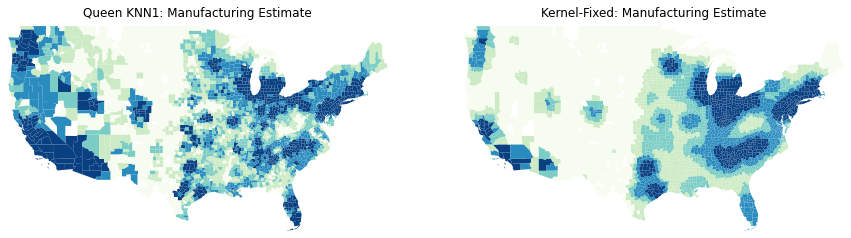

In [ ]:
from bokeh.models.annotations import LegendItem
gdf['lag_wm1'] = ylag1
gdf['lag_wm3'] = ylag3
f,ax = plt.subplots(1,2,figsize=(15,15), subplot_kw=dict(aspect='equal'))
gdf.plot(column='lag_wm1', ax=ax[0], edgecolor='None',
        scheme="quantiles",  k=5, cmap='GnBu')#,legend=True
ax[0].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Queen KNN1: Manufacturing Estimate")
gdf.plot(column='lag_wm3', ax=ax[1], edgecolor='None',
        scheme='quantiles', cmap='GnBu', k=5)#,legend=True
ax[1].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Kernel-Fixed: Manufacturing Estimate")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [ ]:
z = gdf['pctManu']
zlag1 = weights.lag_spatial(wm1, z)
zlag3=weights.lag_spatial(wm3,z)

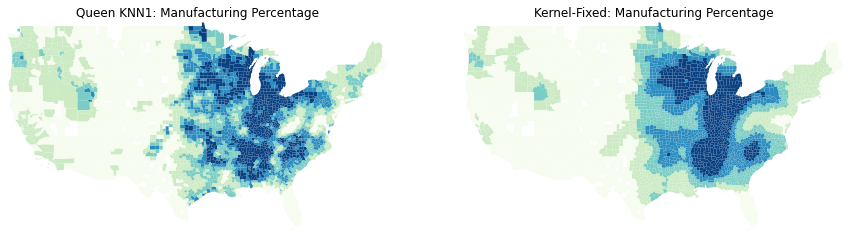

In [ ]:
from bokeh.models.annotations import LegendItem
gdf['zlag_wm1'] = zlag1
gdf['zlag_wm3'] = zlag3
f,ax = plt.subplots(1,2,figsize=(15,15), subplot_kw=dict(aspect='equal'))
gdf.plot(column='zlag_wm1', ax=ax[0], edgecolor='None',
        scheme="quantiles",  k=5, cmap='GnBu')#,legend=True
ax[0].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Queen KNN1: Manufacturing Percentage")
gdf.plot(column='zlag_wm3', ax=ax[1], edgecolor='None',
        scheme='quantiles', cmap='GnBu', k=5)#,legend=True
ax[1].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Kernel-Fixed: Manufacturing Percentage")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [ ]:
x = gdf['HESEst']
xlag1 = weights.lag_spatial(wm1, x)
xlag3=weights.lag_spatial(wm3,x)

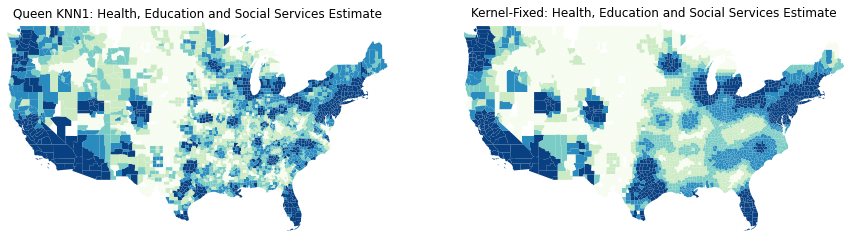

In [ ]:
from bokeh.models.annotations import LegendItem
gdf['xlag_wm1'] = xlag1
gdf['xlag_wm3'] = xlag3
f,ax = plt.subplots(1,2,figsize=(15,15), subplot_kw=dict(aspect='equal'))
gdf.plot(column='xlag_wm1', ax=ax[0], edgecolor='None',
        scheme="quantiles",  k=5, cmap='GnBu')#,legend=True
ax[0].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Queen KNN1: Health, Education and Social Services Estimate")
gdf.plot(column='xlag_wm3', ax=ax[1], edgecolor='None',
        scheme='quantiles', cmap='GnBu', k=5)#,legend=True
ax[1].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Kernel-Fixed: Health, Education and Social Services Estimate")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [ ]:
t = gdf['pctHES']
tlag1 = weights.lag_spatial(wm1, t)
tlag3=weights.lag_spatial(wm3,t)

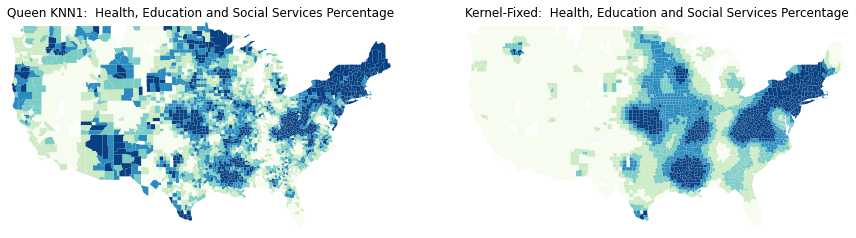

In [ ]:
from bokeh.models.annotations import LegendItem
gdf['tlag_wm1'] = tlag1
gdf['tlag_wm3'] = tlag3
f,ax = plt.subplots(1,2,figsize=(15,15), subplot_kw=dict(aspect='equal'))
gdf.plot(column='tlag_wm1', ax=ax[0], edgecolor='None',
        scheme="quantiles",  k=5, cmap='GnBu')#,legend=True
ax[0].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Queen KNN1:  Health, Education and Social Services Percentage")
gdf.plot(column='tlag_wm3', ax=ax[1], edgecolor='None',
        scheme='quantiles', cmap='GnBu', k=5)#,legend=True
ax[1].axis(gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Kernel-Fixed:  Health, Education and Social Services Percentage")

ax[0].axis('off')
ax[1].axis('off')
plt.show()

# The Use of Global/Local Moran

Global Moran can tell us that values are clustered overall, but it cannot inform us about where the clusters are. For this purpose, we need to use a local measure of spatial autocorrelation. Local measures consider each single observation in a dataset and operate on them, as oposed to on the overall data, as global measures do. Because of that, they allow to obtain further insight.

If the values in the dataset tend to cluster spatially (high values cluster near other high values; low values cluster near other low values), the Moran's Index will be positive. When high values repel other high values, and tend to be near low values, the Index will be negative.

*Source: [Darribas Org](https://darribas.org/gds16/content/labs/lab_05.html)*

In [ ]:
import esda
import seaborn as sbn

# 3

#### Join Counts

In [ ]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
gdf['yb'] = yb

In [ ]:
y = gdf['ManuEst']
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
gdf['yb'] = yb

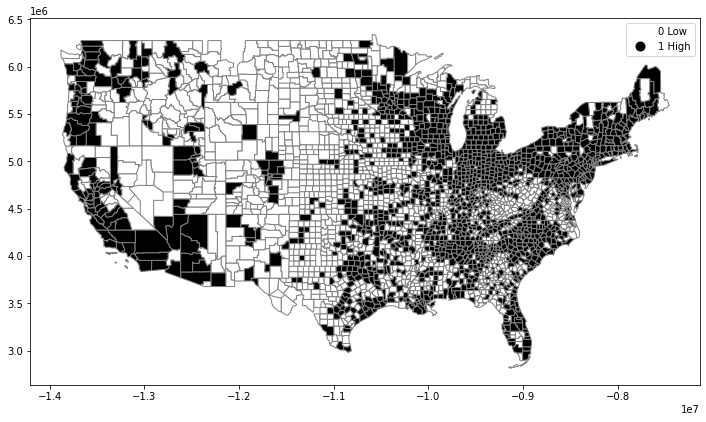

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
gdf.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax);

#### 3a.i

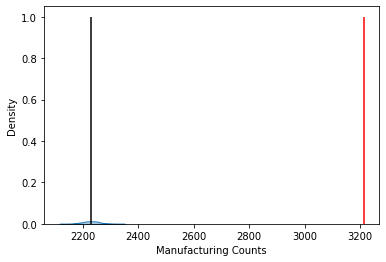

In [ ]:
yb = 1 * (y > y.median()) # convert back to binary
wm1.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wm1)
jc.bb,jc.ww,jc.bw

jc.mean_bb

jcsim = jc.sim_bb.astype(float)
sbn.kdeplot(jcsim, shade=True)
plt.vlines(jc.bb, 0, 1, color='r')#red line at observed value
plt.vlines(jc.mean_bb, 0,1)# black line at mean value
plt.xlabel('Manufacturing Counts');

#### Interpretation

The observed BB joins is significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

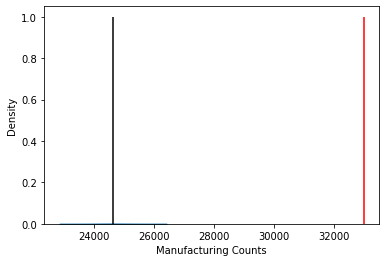

In [ ]:
wm3.transform = 'b'
np.random.seed(12345)
jc3 = esda.join_counts.Join_Counts(yb, wm3)
jc3.bb,jc3.ww,jc3.bw

jc3.mean_bb

jcsim3 = jc3.sim_bb.astype(float)
sbn.kdeplot(jcsim3, shade=True)
plt.vlines(jc3.bb, 0, 1, color='r')#red line at observed value
plt.vlines(jc3.mean_bb, 0,1)# black line at mean value
plt.xlabel('Manufacturing Counts');

#### Interpretation

The observed BB joins is significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

### 3b

In [ ]:
wm1.transform='r'
np.random.seed(12345)
mi = esda.moran.Moran(y, wm1) #
mi.I

0.37287099709213634

In [ ]:
wm3.transform='r'
np.random.seed(12345)
mi3 = esda.moran.Moran(y, wm3) #
mi3.I

0.41165086944233

## Interpretation

Both weighting methods result in positive correlation.

## 3c

In [ ]:
li = esda.moran.Moran_Local(y, wm1)
li3 = esda.moran.Moran_Local(y,wm3)

In [ ]:
from splot.esda import plot_local_autocorrelation
#from splot.esda import plot_global_autocorrelation

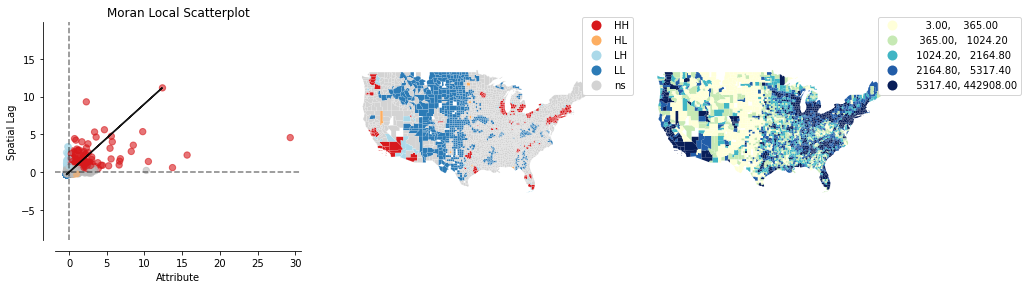

In [ ]:
plot_local_autocorrelation(li, gdf, 'ManuEst')  #Queen
plt.show()

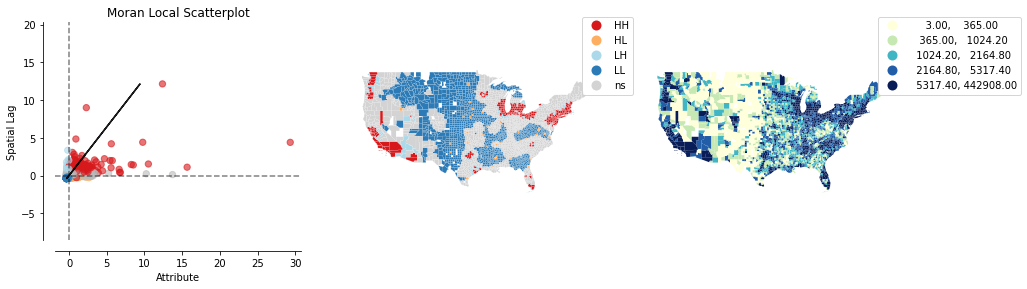

In [ ]:
plot_local_autocorrelation(li3, gdf, 'ManuEst') #Fixed
plt.show()

## Interpretation

In both the Queen-KNN and Fixed weight methods, the hot spots for the population of manufacturing Workers alone are distributed in all regions with the south west and north east counties having most significance/hot spots.

The fixed kernel method reults in more counties considered as significant cold spots.

Both methods identify the midwest counties as cold spots.

# 4.

#### Join Counts

In [ ]:
z = gdf['pctManu']
zb = z > z.median()
labels = ["0 Low", "1 High"]
zb = [labels[i] for i in 1*zb]
gdf['zb'] = zb

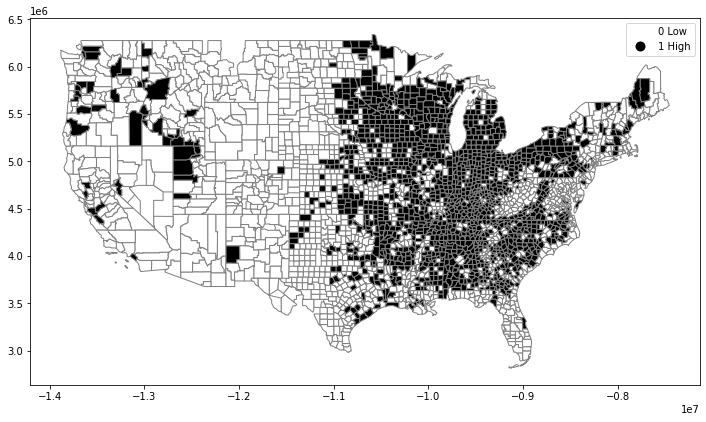

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
gdf.plot(column='zb', cmap='binary', edgecolor='grey', legend=True, ax=ax);

#### 4a.i

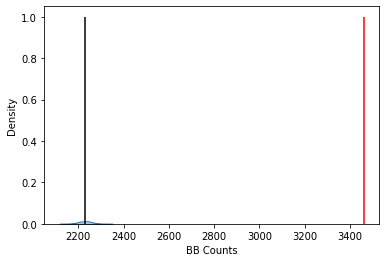

In [ ]:
zb = 1 * (z > z.median()) # convert back to binary
wm1.transform = 'b'
np.random.seed(12345)
jo = esda.join_counts.Join_Counts(zb, wm1)
jo.bb,jo.ww,jo.bw

jo.mean_bb

josim = jo.sim_bb.astype(float)
sbn.kdeplot(josim, shade=True)
plt.vlines(jo.bb, 0, 1, color='r')#red line at observed value
plt.vlines(jo.mean_bb, 0,1)# black line at mean value
plt.xlabel('BB Counts');

#### Interpretation

The observed BB joins is significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

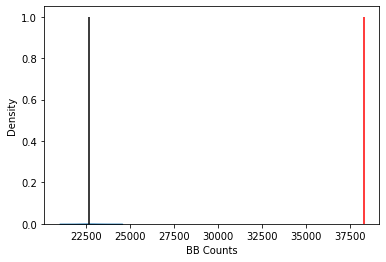

In [ ]:
wm3.transform = 'b'
np.random.seed(12345)
jo3 = esda.join_counts.Join_Counts(zb, wm3)
jo3.bb,jo3.ww,jo3.bw

jo3.mean_bb

josim3 = jo3.sim_bb.astype(float)
sbn.kdeplot(josim3, shade=True)
plt.vlines(jo3.bb, 0, 1, color='r')#red line at observed value
plt.vlines(jo3.mean_bb, 0,1)# black line at mean value
plt.xlabel('BB Counts');

#### Interpretation

The observed BB joins is significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

### 4b

In [ ]:
wm1.transform='r'
np.random.seed(12345)
mo = esda.moran.Moran(z, wm1) #
mo.I

0.6419661373376737

In [ ]:
wm3.transform='r'
np.random.seed(12345)
mo3 = esda.moran.Moran(z, wm3) #
mo3.I

0.5454099863215279

## Interpretation

Both weighting methods result in strong positive correlation.

## 4c

In [ ]:
lo = esda.moran.Moran_Local(z, wm1)
lo3 = esda.moran.Moran_Local(z,wm3)

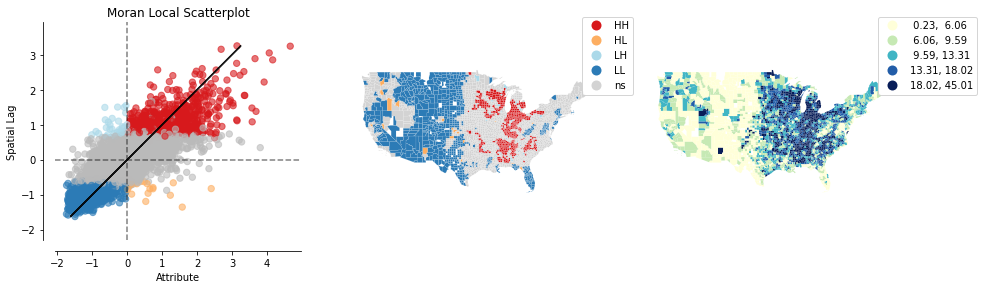

In [ ]:
plot_local_autocorrelation(lo, gdf, 'pctManu') #Queen
plt.show()

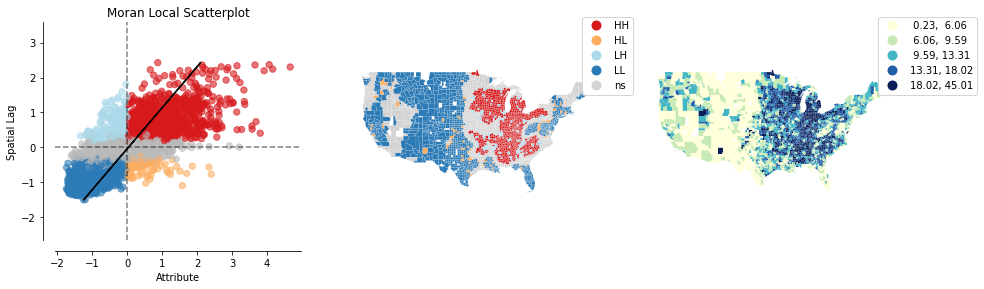

In [ ]:
plot_local_autocorrelation(lo3, gdf, 'pctManu') #Fixed
plt.show()

## Interpretation

In both the Queen-KNN and Fixed weight methods, the hot spots for the percent population of manufacturing Workers alone are distributed in all regions with the east counties having most significance/hot spots.

The fixed kernel method reults in more counties consider as significant hot spots.

Both methods identify the west counties and most of midwest counties as cold spots.

# 5.

#### Join Counts

In [ ]:
x = gdf['HESEst']
xb = x > x.median()
labels = ["0 Low", "1 High"]
xb = [labels[i] for i in 1*xb]
gdf['xb'] = xb

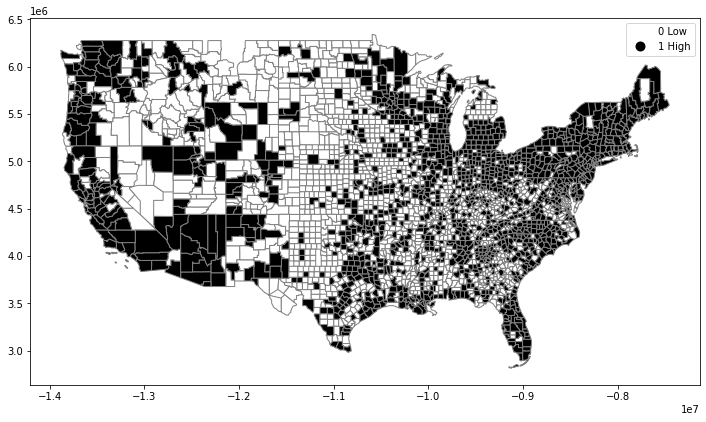

In [ ]:
fig = plt.figure(figsize=(12,10))
ax = plt.gca()
gdf.plot(column='xb', cmap='binary', edgecolor='grey', legend=True, ax=ax);

#### 5a.i

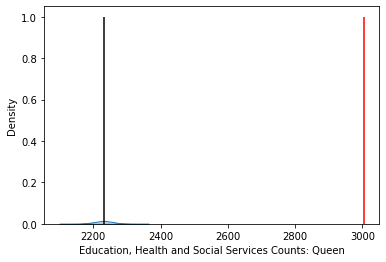

In [ ]:
xb = 1 * (x > x.median()) # convert back to binary
wm1.transform = 'b'
np.random.seed(12345)
je = esda.join_counts.Join_Counts(xb, wm1)
je.bb,je.ww,je.bw

je.mean_bb

jesim = je.sim_bb.astype(float)
sbn.kdeplot(jesim, shade=True)
plt.vlines(je.bb, 0, 1, color='r')#red line at observed value
plt.vlines(je.mean_bb, 0,1)# black line at mean value
plt.xlabel('Education, Health and Social Services Counts: Queen');

#### Interpretation

The observed BB joins is not significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

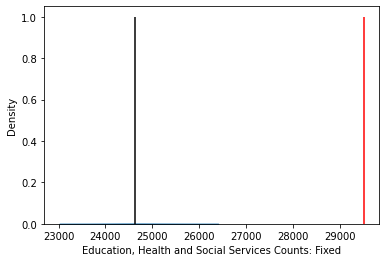

In [ ]:
wm3.transform = 'b'
np.random.seed(12345)
je3 = esda.join_counts.Join_Counts(xb, wm3)
je3.bb,je3.ww,je3.bw

je3.mean_bb

jesim3 = je3.sim_bb.astype(float)
sbn.kdeplot(jesim3, shade=True)
plt.vlines(je3.bb, 0, 1, color='r')#red line at observed value
plt.vlines(je3.mean_bb, 0,1)# black line at mean value
plt.xlabel('Education, Health and Social Services Counts: Fixed');

#### Interpretation

The observed BB joins is not significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

### 5b

In [ ]:
wm1.transform='r'
np.random.seed(12345)
me = esda.moran.Moran(x, wm1) #
me.I

0.37267721934527487

In [ ]:
wm3.transform='r'
np.random.seed(12345)
me3 = esda.moran.Moran(x, wm3) #
me3.I

0.39916942905479663

## Interpretation

Both weighting methods result in positive correlation.

## 5c


In [ ]:
le = esda.moran.Moran_Local(x, wm1)
le3 = esda.moran.Moran_Local(x,wm3)

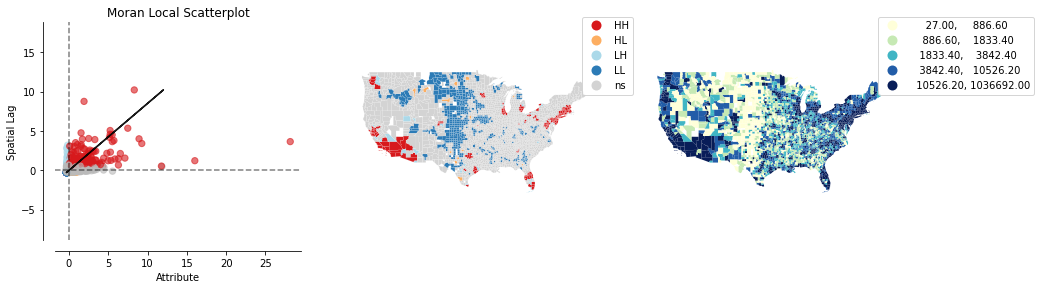

In [ ]:
plot_local_autocorrelation(le, gdf, 'HESEst') #Queen
plt.show()

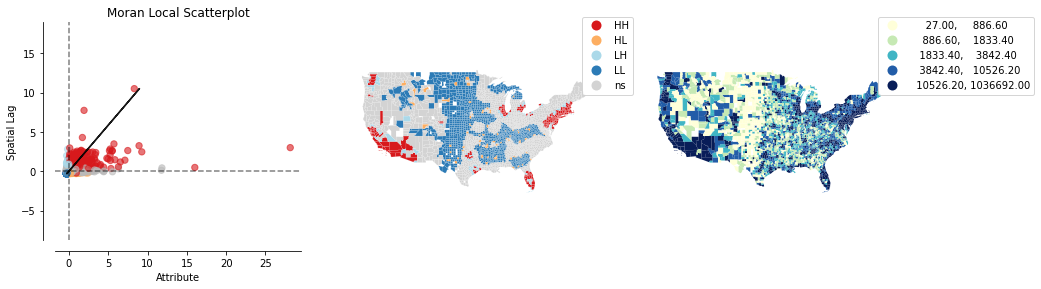

In [ ]:
plot_local_autocorrelation(le3, gdf, 'HESEst') #Fixed
plt.show()

## Interpretation

In both the Queen-KNN and Fixed weight methods, the hot spots for the population of Educational Services, Health Care and Social Assistance Workers alone are distributed in all regions with the south west counties having most hot spots and midwest counties as having most cold spots.

The Queen-KNN method results in more counties consider as significant hot spots.

Queen-KNN methods identify the eastern counties as containing the most insignificant values. While Fixed weight method identifies western counties as containing the most insignificant values.


# 6.

#### Join Counts

In [ ]:
t = gdf['pctHES']
tb = t > t.median()
labels = ["0 Low", "1 High"]
tb = [labels[i] for i in 1*tb]
gdf['tb'] = tb

#### 6a.i

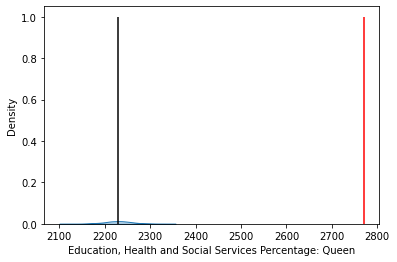

In [ ]:
tb = 1 * (t > t.median()) # convert back to binary
wm1.transform = 'b'
np.random.seed(12345)
ju = esda.join_counts.Join_Counts(tb, wm1)
ju.bb,ju.ww,ju.bw

ju.mean_bb

jusim = ju.sim_bb.astype(float)
sbn.kdeplot(jusim, shade=True)
plt.vlines(ju.bb, 0, 1, color='r')#red line at observed value
plt.vlines(ju.mean_bb, 0,1)# black line at mean value
plt.xlabel('Education, Health and Social Services Percentage: Queen');

#### Interpretation

The observed BB joins is not significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

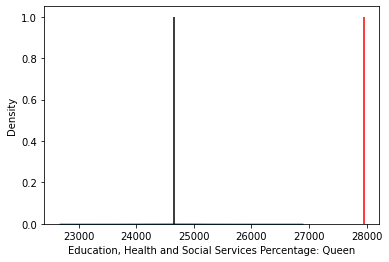

In [ ]:
wm3.transform = 'b'
np.random.seed(12345)
ju3 = esda.join_counts.Join_Counts(tb, wm3)
ju3.bb,ju3.ww,ju3.bw

ju3.mean_bb

jusim3 = ju3.sim_bb.astype(float)
sbn.kdeplot(jusim3, shade=True)
plt.vlines(ju3.bb, 0, 1, color='r')#red line at observed value
plt.vlines(ju3.mean_bb, 0,1)# black line at mean value
plt.xlabel('Education, Health and Social Services Percentage: Queen');

#### Interpretation

The observed BB joins is not significantly larger than the expected BB joins. This pattern is not attributable to a CSR process.

### 6b

In [ ]:
wm1.transform='r'
np.random.seed(12345)
mu = esda.moran.Moran(t, wm1) #
mu.I

0.282904403964493

In [ ]:
wm3.transform='r'
np.random.seed(12345)
mu3 = esda.moran.Moran(t, wm3) #
mu3.I

0.2646001896262742

## Interpretation

Both weighting methods result in weak positive correlation.

### 6c

In [ ]:
lu = esda.moran.Moran_Local(t, wm1)
lu3 = esda.moran.Moran_Local(t,wm3)

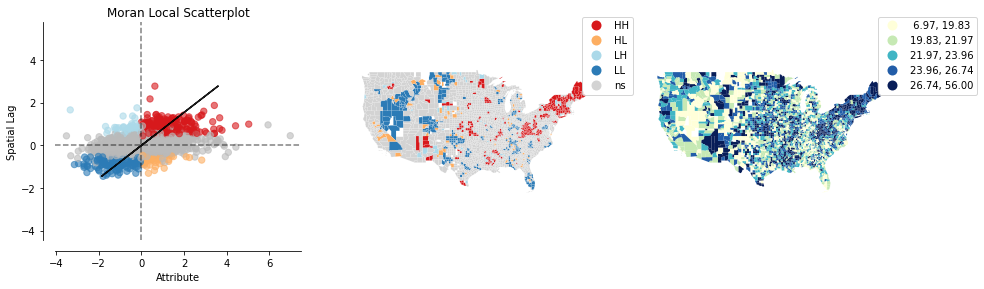

In [ ]:
plot_local_autocorrelation(lu, gdf, 'pctHES') #Queen
plt.show()

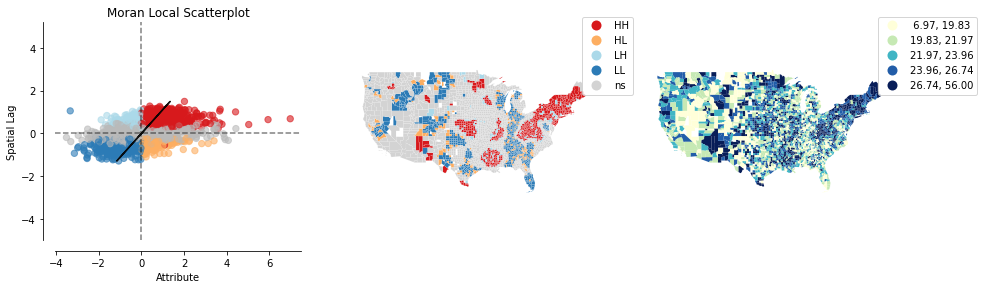

In [ ]:
plot_local_autocorrelation(lu3, gdf, 'pctHES') #Fixed
plt.show()

## Interpretation

In both the Queen-KNN and Fixed weight methods, the hot spots for the percent population of Educational Services, Health Care and Social Assistance Workers alone are distributed in all regions with the north east counties having most significance.

The fixed kernel method reults in more counties consider as significant hot spots.

Both methods identify the south west counties and most of north west counties as insignificant values.

In [ ]:
fn = "workdata.shp"
gdf['rankManu']=gdf['rankManu'].astype(str)
gdf['rankHES']=gdf['rankHES'].astype(str)
gdf.to_file(mypath+fn)